## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import torchvision
import ssim

import shiftpatch_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [20]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 2**0
    ,loaderWorkers = 16
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-4
    ,learningRateG = 1e-4
)

sg.DCfg = sg.DCfgClass()


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.samplingMask = sg.SamplingMask()
sg.samplingVari = sg.SamplingVariations()
sg.trainSet = sg.createTrainSet()
sg.testSet = sg.createTestSet()
sg.testLoader = sg.createDataLoader(sg.createSubSet(sg.testSet),
                                    num_workers=sg.TCfg.loaderWorkers)
sg.refImages, sg.refNoises = sg.createReferences(0)

### <font style="color:lightblue">Show</font>

(0, 23, 311, 712)


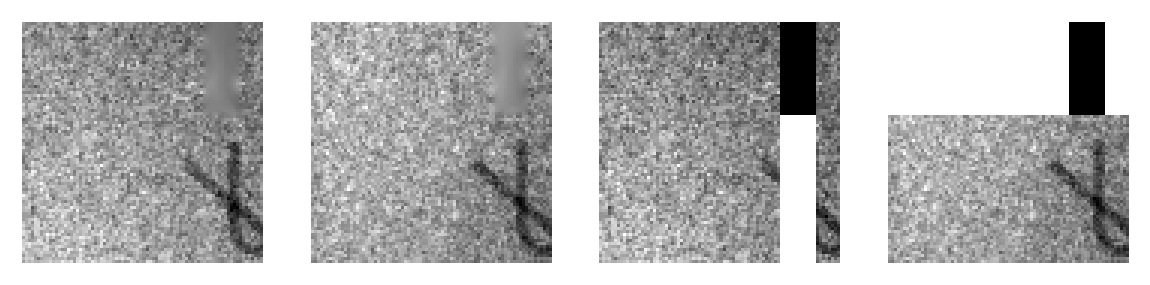

In [5]:

sg.showMe(sg.testSet)

## <font style="color:lightblue">Models</font>

In [6]:
sg.batchNormOpt = { #"track_running_stats" : False,
                    #"momentum" : 0.5,
                  }

### <font style="color:lightblue">Generator</font>

In [ ]:
save_interim = False
class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(latentChannels=1, inputChannels=2)
        self.amplitude = 1
        self.baseChannels = 16

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (self.inputChannels+abs(self.latentChannels)) /self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=True, dopadding=True),
            self.encblock( 1,  2, 3, norm=True, stride=2),
            self.encblock( 2,  2, 3, norm=True, dopadding=True),
            self.encblock( 2,  4, 3, norm=True, stride=2),
            self.encblock( 4,  4, 3, norm=True, dopadding=True),
            self.encblock( 4,  8, 3, norm=True, stride=2),
            self.encblock( 8,  8, 3, norm=True, dopadding=True),
            self.encblock( 8, 16, 3, norm=True, stride=2),
            self.encblock(16, 16, 3, norm=True, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, norm=True, dopadding=True),
            self.decblock(32,  8, 4, norm=True, stride=2),
            self.decblock(16,  8, 3, norm=True, dopadding=True),
            self.decblock(16,  4, 4, norm=True, stride=2),
            self.decblock( 8,  4, 3, norm=True, dopadding=True),
            self.decblock( 8,  2, 4, norm=True, stride=2),
            self.decblock( 4,  2, 3, norm=True, dopadding=True),
            self.decblock( 4,  1, 4, norm=True, stride=2),
            self.decblock( 2,  1, 3, norm=True, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        sg.load_model(self, model_path="good_0_gen.pt" )


sg.generator = Generator().to(sg.TCfg.device)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0,1],0:4,...], sg.refNoises[[0,1],...]] ] ).__str__()
#print(model_summary)

#checkPoint = torch.load("saves/mssim_mili/checkPoint.pth", map_location=sg.TCfg.device, weights_only=False)
#sg.optimizer_G.load_state_dict(checkPoint['optimizerGen'])
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()


#_ = sg.testMe(sg.refImages)

### <font style="color:lightblue">Discriminator</font>

In [ ]:
sg.discriminatePair = True
class DiscriminatorIMG(sg.DiscriminatorTemplate):
    def __init__(self):
        super(DiscriminatorIMG, self).__init__()
        self.baseChannels = 16
        self.body =  nn.Sequential(
            self.encblock( 2/self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=False, dopadding=True),
            self.encblock( 1,  2, 3, norm=False, stride=2),
            self.encblock( 2,  2, 3, norm=False, dopadding=True),
            self.encblock( 2,  4, 3, norm=False, stride=2),
            self.encblock( 4,  4, 3, norm=False, dopadding=True),
            self.encblock( 4,  8, 3, norm=False, stride=2),
            self.encblock( 8,  8, 3, norm=False, dopadding=True),
            self.encblock( 8, 16, 3, norm=False, stride=2),
            self.encblock(16, 16, 3, norm=False, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="saves/msssim1_noFFT/model_dis.pt" )


fftNorm = torch.tensor(sg.loadImage("NormFFT.tif"), device=sg.TCfg.device)[None,None,...]

class DiscriminatorFFT(sg.DiscriminatorTemplate):

    def __init__(self):
        super(DiscriminatorFFT, self).__init__()
        self.baseChannels = 16
        self.chIn = 2
        self.body =  nn.Sequential(
            self.encblock( self.chIn/self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=False, dopadding=True),
            self.encblock( 1,  2, 3, norm=False, stride=2),
            self.encblock( 2,  2, 3, norm=False, dopadding=True),
            self.encblock( 2,  4, 3, norm=False, stride=2),
            self.encblock( 4,  4, 3, norm=False, dopadding=True),
            self.encblock( 4,  8, 3, norm=False, stride=2),
            self.encblock( 8,  8, 3, norm=False, dopadding=True),
            self.encblock( 8, 16, 3, norm=False, stride=2),
            self.encblock(16, 16, 3, norm=False, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="/data/anton/shiftpatch/model_dis_fft.pt" )

    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        fftIO = images[:,[0],...] + 1j * images[:,[1],...]
        fftIO = torch.fft.fft2(fftIO, norm="forward") / fftNorm
        modelIn = torch.concat( (fftIO.real, fftIO.imag), dim=1 )
        convRes = self.body(modelIn)
        res = self.head(convRes)
        return res


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discIMG = DiscriminatorIMG()
        self.discFFT = DiscriminatorFFT()
        self.IMG_FFT = 0.5
        sg.load_model(self, model_path="good_0_dis.pt" )
    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        resIMG = self.discIMG(images) if self.IMG_FFT > 0 else 0
        resFFT = self.discFFT(images) if self.IMG_FFT < 1 else 0
        res = self.IMG_FFT * resIMG + (1-self.IMG_FFT) * resFFT
        #print(resIMG, resFFT)
        return res


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[[0],0:2,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 1).step()



## Loss

In [9]:
sg.noAdv = False
sg.MSSSIM = ssim.MS_SSIM(data_range=2.0, size_average=False, channel=1, win_size=1)
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L = sg.summarizeSet(sg.testLoader)[0:3]
#print(f"{sg.normTestRec:.3e}, {sg.normTestMSE:.3e}, {sg.normTestL1L:.3e}")
#sg.normRec, sg.normMSE, sg.normL1L = sg.summarizeSet(
#                                            sg.createDataLoader(
#                                                sg.createSubSet(sg.trainSet),
#                                                num_workers=sg.TCfg.loaderWorkers))[0:3]
#print(f"{sg.normRec:.3e}, {sg.normMSE:.3e}, {sg.normL1L:.3e}")

#sg.normTestRec, sg.normTestMSE, sg.normTestL1L =  3.185e-03, 3.845e-04, 6.890e-03 # 8.905e-05, 4.314e-04, 7.362e-03
#sg.normRec, sg.normMSE, sg.normL1L = 1.443e-02, 2.267e-03, 1.797e-02 # 1.170e-04, 1.915e-03, 1.639e-02
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 5.100e-05, 3.864e-04, 6.929e-03
sg.normRec, sg.normMSE, sg.normL1L = 6.128e-05, 1.838e-03, 1.604e-02


# SSIM:   bs0 4.463e-02, 1.044e-02 # bsMean 4.503e-02, 1.025e-02 # bs- 4.448e-02, 1.028e-02 # mskMean 4.739e-02, 1.078e-02
# MSSSIM: bs0 1.431e-02, 3.716e-03 # bsMean 1.443e-02, 3.185e-03 # bs- 1.354e-02, 3.096e-03



## <font style="color:lightblue">Restore checkpoint</font>

In [13]:
sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minRecTest, sg.minRecTrain, sg.minTestEpoch, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)

sg.scheduler_G.gamma = 1-0.002
sg.scheduler_D.gamma = 1-0.002
sg.optimizer_G.step()
sg.optimizer_D.step()
torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 0.1).step()
torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.1).step()

#sg.startFrom = 0
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0

#sg.epoch = 0
#sg.imer = 0
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
print(f"Initial LR :{sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG} {sg.epoch} {sg.imer}")

Initial LR :0.1 0 0


## Test me

Losses: Rec 1.538e-02, MSE 2.342e-01, L1L 2.395e-01, Dis: 0.693151 (0.499), Adv: 0.695 (0.499), Gen: 1.579e-02, Pixels: 10573.0.


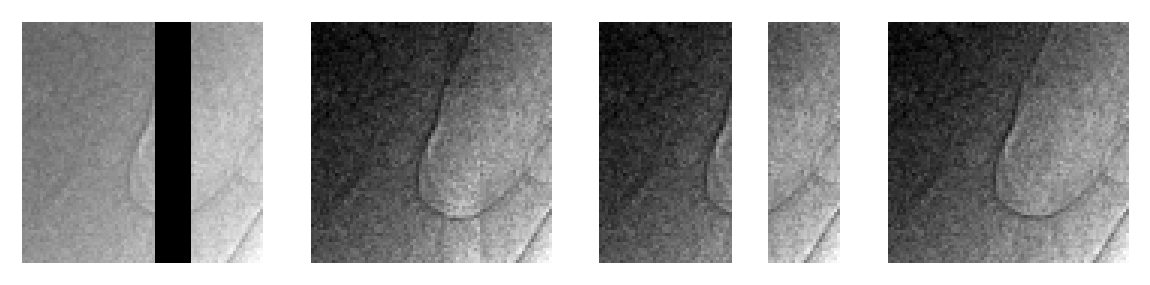

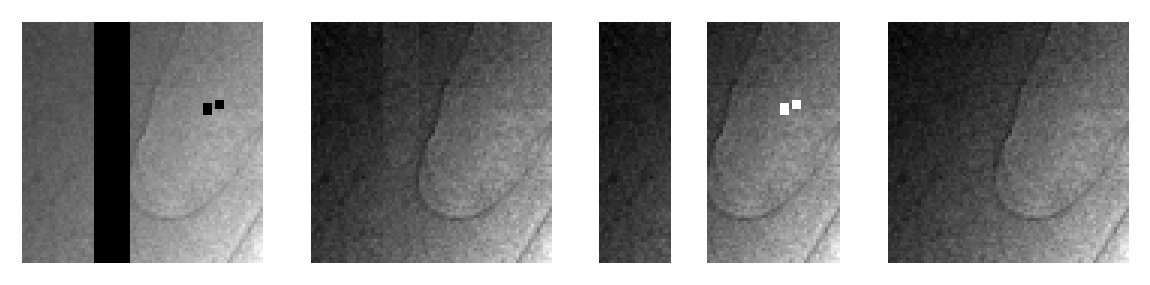

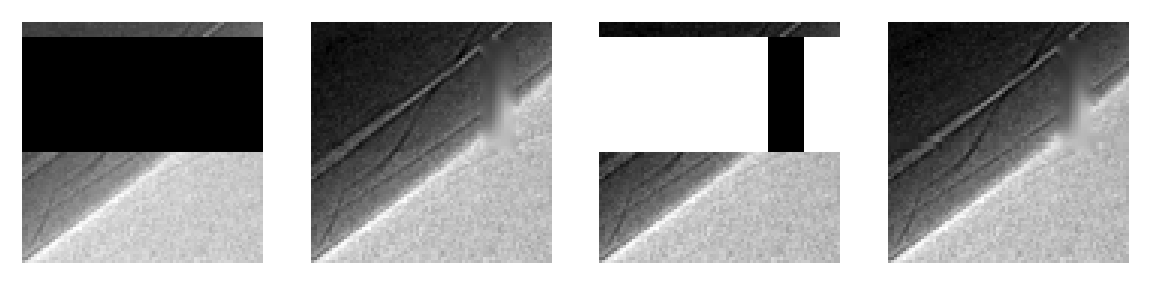

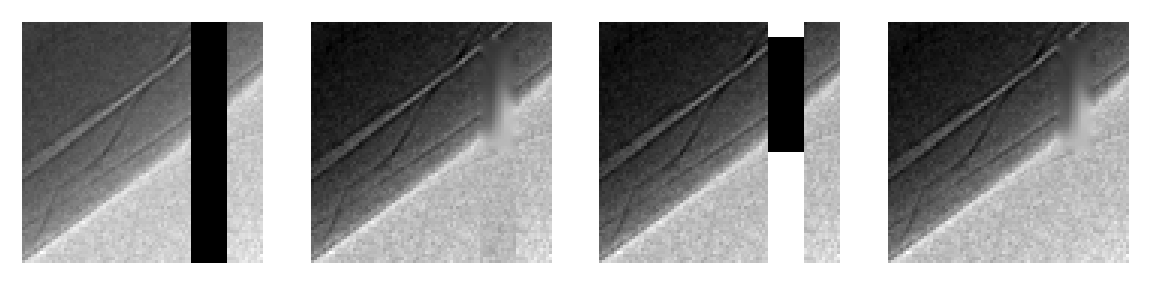

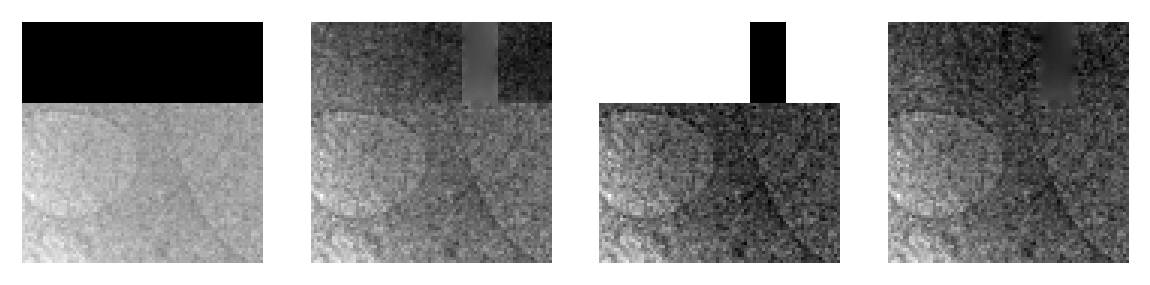

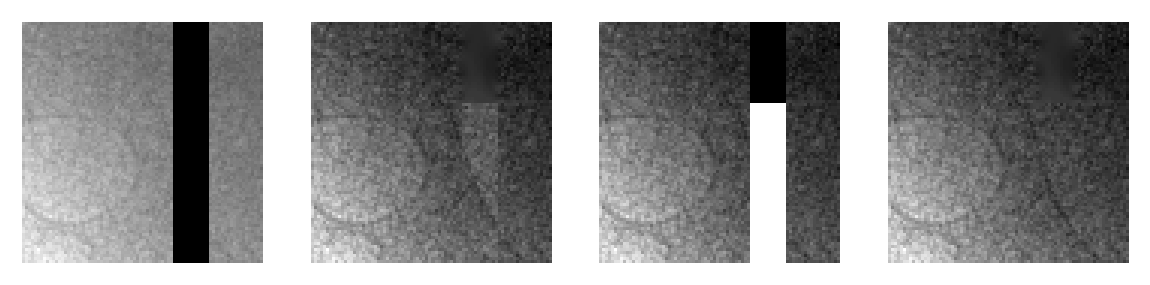

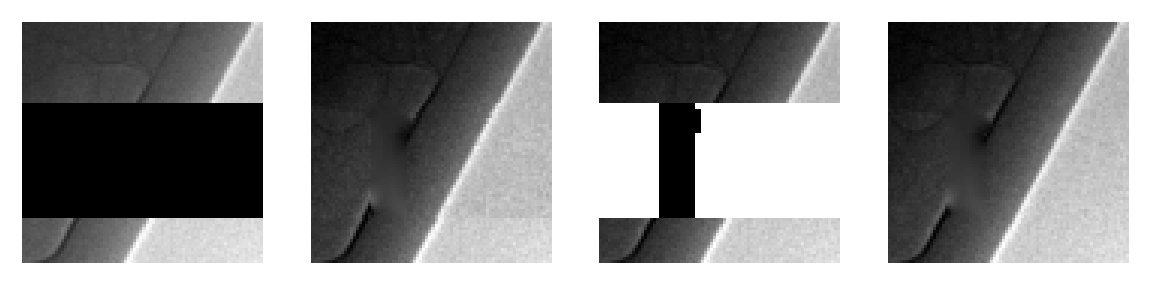

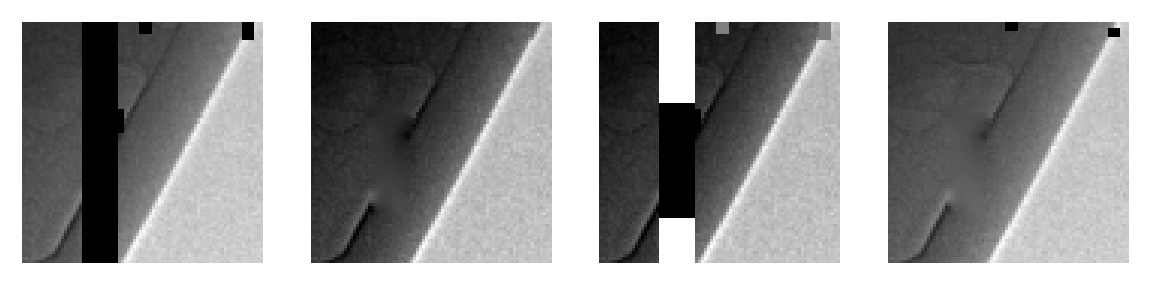

In [14]:
#sg.load_model(sg.discriminator, model_path="model_0_dis.pt" )

_ = sg.testMe(sg.refImages)


## <font style="color:lightblue">Execute</font>

In [15]:
sg.freeGPUmem()

 inmask : 1.000e+00.
Epoch:  11 (  8). (Train: 1.014/0.804, Test: 13597.637/13544.300).
Update (1.0e+00/1.0e+00).                Dis: 0.693 (0.500)  Adv: 0.693 (0.500)  Gen: 1.000  Rec: 0.782 
Random image (1, 390, 82, 1184).         Dis: 0.693 (0.497)  Adv: 0.697 (0.497)  Gen: 1.006  Rec: 0.098 
Reference images.                        Dis: 0.693 (0.502)  Adv: 0.691 (0.502)  Gen: 0.996  Rec: 0.146 


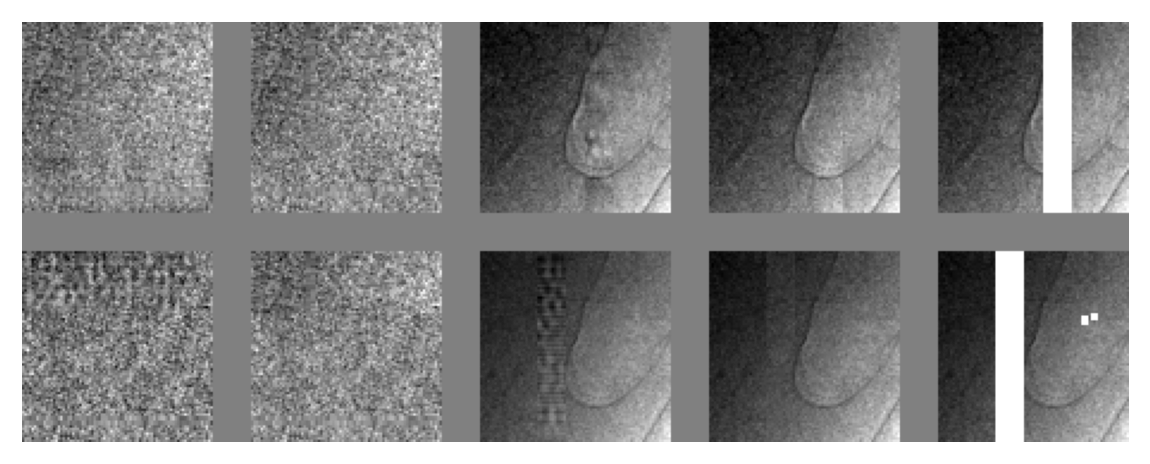

 83%|████████▎ | 10018/12016 [1:12:11<14:28,  2.30it/s]

In [ ]:
#torch.autograd.set_detect_anomaly(True)


#sg.minRecTest, sg.minRecTrain = 1, 1
sg.ADV_DIF = 1 # 0.008108
sg.trainCyclesGen = 0
sg.trainCyclesDis = 1
sg.generator.inmask = 3.9e-1
sg.skipThreshold = 0
sg.discriminator.IMG_FFT = 1

def adjustScheduler(scheduler, iniLr, target) :
    if scheduler is None :
        return ""
    gamma = scheduler.gamma
    curLR = scheduler.get_last_lr()[0] / iniLr
    if gamma < 1 and curLR > target \
    or gamma > 1 and curLR < target :
        scheduler.step()
    return f"LR : {curLR:.2e}. "

import os
def my_beforeReport(sglocals) :
    message = ""
    if os.path.isfile("prime_0_dis.pt") :
        message += f" inmask : {sg.generator.inmask:.3e}."
        sg.generator.inmask = min(1, sg.generator.inmask+0.005)
    elif abs(sglocals['updAcc'].predReal - sglocals['updAcc'].predFake) > 0.1 :
        sg.saveModels("prime_0")
        #sg.trainCyclesGen = 1
    if abs(sglocals['updAcc'].predReal - sglocals['updAcc'].predFake) > 0.1 \
    and 1.01 > (sglocals['updAcc'].predReal + sglocals['updAcc'].predFake) > 0.99 :
        sg.saveModels("good_0")
    if sg.generator.inmask >= 1 :
        if not sg.trainCyclesGen:
            message += f" Starting generator training {sg.epoch}. "
        sg.trainCyclesGen = 1
    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
        file.write(message + "\n")
    print(message)
sg.beforeReport = my_beforeReport


#sg.TCfg.loaderWorkers = 0 # for debug single threaded
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderrelo
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise

# from scratch
# ADV_DIFF = 1, LR = 0.1


## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()